In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.nn.functional as F
import math
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
import collections

# Movie Review Data Cleaning

In [0]:
def read_raw(file_name, label):
  with open(file_name, 'r') as file:
    data = []
    for line in file:
        processed_line = preprocess_raw(line)
        data.append([processed_line.split(), label])
  return data

def preprocess_raw(text):
  text = text.replace('\u202f', ' ').replace('\xa0', ' ')
  out = ''
  for i, char in enumerate(text.lower()):
    if char.isalpha()==True or char==' ':
      out += char
  out=" ".join(out.split())
  return out

def build_data(direc):
  data=[]
  counter=0
  for label in ['pos', 'neg']:
    label_direc = os.path.join(direc, label)
    for filename in os.listdir(label_direc):
      if (label == 'pos'):
        data += read_raw(os.path.join(label_direc,str(filename)), 1)
      else:
        data += read_raw(os.path.join(label_direc,str(filename)), 0)
      counter += 1
  print('Done')
  return data

In [0]:
data = build_data('./txt_sentoken/')

Done


# Data to File

In [0]:
data = np.array(data)
file = open('data', 'wb')
pickle.dump(data, file)
file.close()

# Movie Review Dataset

In [0]:
class MovieReviewDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.data = dataset
        self.transform = transform
    
    def __getitem__(self, idx):
        temp = self.data[idx]
        if (self.transform):
            temp = self.transform(sample)
        
        sample = {'sentence': temp[0] ,'label': temp[1]}
        return sample
    
    def __len__(self):
        return len(self.data)            

# Load data file

In [0]:
file = open('/content/drive/My Drive/ML Final/data', 'rb')
data = pickle.load(file)
file.close()

# Train Embedding Model

In [0]:
embed_model = Word2Vec(size=300, min_count=1)
embed_model.build_vocab(data[:,0])
total_examples = embed_model.corpus_count
pretrained = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
embed_model.build_vocab([list(pretrained.vocab.keys())], update=True)
embed_model.intersect_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
embed_model.train(data[:,0], total_examples=total_examples, epochs=embed_model.iter)

# Save embedding model

In [0]:
embed_model.wv.save('embedding_model')

# Figures to determine max_freq and sentence length cutoff

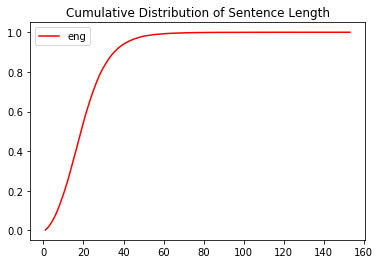

In [0]:
text=data[:,0]
import collections
import numpy as np
import matplotlib.pyplot as plt
def len_dis(text):
  lens = [len(line) for line in text]
  len_counter = collections.Counter(lens)

  lens = np.array(list(len_counter.keys()))
  sort_idx = np.argsort(lens)
  lens_sort = lens[sort_idx]
  len_counts = np.array(list(len_counter.values()))
  len_counts_sort = len_counts[sort_idx]
  p = np.cumsum(len_counts_sort) / len_counts_sort.sum()
  return p, lens_sort
  
src_p, src_lens_sort = len_dis(text)
plt.plot(src_lens_sort, src_p, 'r-', label='eng')
plt.title('Cumulative Distribution of Sentence Length')
plt.legend()
plt.show()

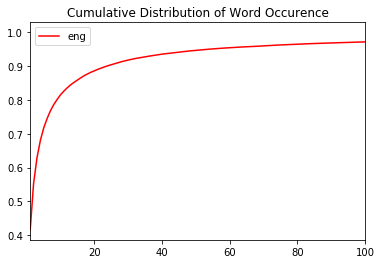

In [0]:
def len_dis(text):
  words = [token for line in text for token in line]
  word_counter = collections.Counter(words)
  freq_counter=  collections.Counter(word_counter.values())
  freqs = np.array(list(freq_counter.keys()))
  freq_length = np.array(list(freq_counter.values()))
  sort_idx= np.argsort(freqs)
  freq_sort = freqs[sort_idx]
  freq_length = np.array(list(freq_counter.values()))
  freq_length_sort = freq_length[sort_idx]
  p = np.cumsum(freq_length_sort) / freq_length_sort.sum()
  return p, freq_sort
  
src_p, src_lens_sort = len_dis(text)
plt.plot(src_lens_sort, src_p, 'r-', label='eng')
plt.title('Cumulative Distribution of Word Occurence')
plt.legend()
axes = plt.gca()
axes.set_xlim([1,100])
plt.show()

In [0]:
MIN_FREQ=1
MAX_LEN=50

# Container class for dataset

In [0]:
class Vocab():
  def __init__(self, name, tokens, min_freq):
    self.name = name
    self.index2word = {
      0: 'pad',
      1: 'unk'
    }
    self.word2index = {v: k for k, v in self.index2word.items()}
    self.num_word = 2
    token_freq = collections.Counter(tokens)
    tokens = [token for token in tokens if token_freq[token] >= MIN_FREQ]
    self._build_vocab(tokens)
    
  def _build_vocab(self, tokens):
    for token in tokens:
      if token not in self.word2index:
        self.word2index[token] = self.num_word
        self.index2word[self.num_word] = token
        self.num_word += 1
        
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.word2index.get(tokens, self.word2index['unk'])
    else:
      return [self.__getitem__(token) for token in tokens]

In [0]:
def build_vocab(name, tokens, min_freq):
  sentences=tokens[:,0]
  tokens = [token for sentence in sentences for token in sentence]
  return Vocab(name, tokens, min_freq)

def build_vocabs(lang_src, src_text):
  vocab_src = build_vocab(lang_src, src_text, MIN_FREQ)
  return vocab_src

def pad(line, padding_token):
  return line + [padding_token] * (MAX_LEN-len(line))

def build_tensor(text, reviews_vocab):
  labels=text[:,1]
  lines = [reviews_vocab[line] for line in text[:,0]]
  lst=[]
  for i in range(len(lines)):
    padded_sentence=torch.tensor(pad(lines[i],reviews_vocab['pad']))
    label=torch.tensor(labels[i])
    lst.append([padded_sentence,label])
  return lst

def load_reviews_data():
  reviews_vocab = build_vocabs('reviews', data)
  for i in range(len(data[:,0])):
    data[:,0][i]=data[:,0][i][:MAX_LEN]
  reviews_array = build_tensor(data, reviews_vocab)
  return reviews_vocab,reviews_array


#source, target = prepare_data(raw_text, max_len=MAX_LEN)
#vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size=2)
#print('Vocabulary size of source language: {}'.format(vocab_eng.num_word))
#print('Vocabulary size of target language: {}'.format(vocab_fra.num_word))
#print('Total number of sentence pairs: {}'.format(len(source)))

In [0]:
reviews_vocab,reviews_array=load_reviews_data()

# CRAN used with Pytorch embedding

In [0]:
class CRAN(nn.Module):
  def __init__(self,vocab_size,embedding_size,cnn_window_length,hidden_units,p_dropout):
    super(CRAN, self).__init__()

    """
    inputs:
      cnn_num_filters: the number of convolutional kernels, represents the number of output channels parameter in Conv2d
      cnn_window_length: in a kernel size of d*l, d represents the embedding size and l represents the window length
      LSTM_hidden_units: number of hidden units in LSTM layer
      dropout: dropout probability for CNN
      embedding_size: length of embedded word vectors 
    """
    self.embedding=nn.Embedding(vocab_size,embedding_size)
    self.cnn=torch.nn.Conv2d(1,hidden_units,(cnn_window_length,embedding_size), padding=(1,0))
    self.dropout=torch.nn.Dropout(p_dropout)
    self.rnn=torch.nn.LSTM(embedding_size,hidden_units,1, batch_first=True)
    self.hidden_size = hidden_units
    self.dense = nn.Linear(hidden_units, 2)
  def forward(self,batch,labels):
    word_embedded=self.embedding(batch)
    (N,T,d)=word_embedded.shape
    word_embedded=word_embedded.view(N,1,T,d)
    #apply convolutional filters to the input sentences
    cnn_output=self.cnn(word_embedded)
    #cnn_output will be of shape (N,cnn_num_filters,H_out from Pytorch documentation,1)
    shape=cnn_output.shape
    cnn_output= F.relu(cnn_output.view(N,shape[1],shape[2]))
    #average across the different filter outputs
    cnn_output=torch.mean(cnn_output,1)
    h = batch.new_zeros(1, N, self.hidden_size).float()
    c = batch.new_zeros(1, N, self.hidden_size).float()
    word_embedded=word_embedded.view(N,T,d)
  
    lstm_out, (h,c) = self.rnn(word_embedded, (h, c))

    s = torch.mean(lstm_out * cnn_output.unsqueeze(2), 1)

    pred = F.log_softmax(self.dense(s))
    
    if self.training:
      loss = F.nll_loss(pred, labels)

      return loss, pred.argmax(dim=-1)
    else:
      return pred

# training CRAN with Pytorch embedding

In [0]:
reviews=torch.zeros((len(reviews_array),len(reviews_array[0][0])),dtype=torch.long)
labels=torch.zeros((len(reviews_array)),dtype=torch.long)
for i in range(len(reviews_array)):
  reviews[i]=torch.tensor(reviews_array[i][0])
  labels[i]=torch.tensor(reviews_array[i][1])

batch_size = 16
vocab_size=reviews_vocab.num_word
embedding_dim = 100
hidden_size = 100
cnn_window_length=3
lr = 1e-3
epoch = 10
p_dropout=0.5

CRAN_m = CRAN(vocab_size, embedding_dim, cnn_window_length,hidden_size,p_dropout)
device = torch.device('cuda:0') # cuda:0 if you have gpu
CRAN_m = CRAN_m.to(device)

optimizer = torch.optim.Adam(CRAN_m.parameters(), lr=lr)
loss_list = []
for e in range(epoch):
  CRAN_m.train()
  permutation=torch.randperm(reviews.size()[0])
  for i in range(0,reviews.size()[0],batch_size):
    indices = permutation[i:i+batch_size]
    reviews_batch, labels_batch = reviews[indices], labels[indices]
    reviews_batch=reviews_batch.to(device)
    labels_batch=labels_batch.to(device)
    loss, pred = CRAN_m(reviews_batch,labels_batch)
    loss_list.append(loss.mean().detach())
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    if i%5000==0:
      print(loss.mean())

tensor(0.6880, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6909, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7177, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6778, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6197, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7317, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5475, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5228, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5581, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5063, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5477, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6435, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5599, device='cuda:0', grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

# Google Embedding

In [0]:
class GoogleEmbedding(nn.Module):
  def __init__(self, model_path):
    super(GoogleEmbedding, self).__init__()

    # Load Google's pre-trained Word2Vec model.
    self.model = KeyedVectors.load(model_path, mmap='r')

  def forward(self, batch):
    out = []
    for sent in batch:
      sent_embed = []
      for word in sent:
        sent_embed.append(self.model[word])
      
      sent_embed = np.array(sent_embed)
      out.append(sent_embed)
    return np.array(out)

In [14]:
embedding = GoogleEmbedding('/content/drive/My Drive/ML Final/embedding_model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# removing empty sentences
del_lst=[]
for i in range(len(data)):
    if len(data[:,0][i])==0:
        del_lst.append(i)
data=np.delete(data,del_lst,axis=0)

In [0]:
# limit sentence length
for i in range(len(data)):
    data[:,0][i]=data[:,0][i][:MAX_LEN]

# Embedded Movie Review dataset 

In [0]:
reviews_array=embedding(data[:,0])
labels_array=data[:,1].astype('int32')

In [63]:
for i in range(len(reviews_array)):
    if (i % 1000 == 0):
        print(i)
    avg_vector=np.reshape(np.repeat(np.reshape(np.average(reviews_array[i],axis=0),(1,300)),MAX_LEN-len(reviews_array[i]),axis=0),(MAX_LEN-len(reviews_array[i]),300))
    reviews_array[i]=np.concatenate((reviews_array[i],avg_vector),axis=0)

# stack all reviews to get 3d array
reviews_array = np.stack(reviews_array, axis=0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000


# CRAN with Google embedding attention random init

In [0]:
#CRAN used with word2vec embedding
class CRANword2vec(nn.Module):
  def __init__(self,embedding_size,cnn_window_length,hidden_units,p_dropout):
    super(CRANword2vec, self).__init__()

    """
    inputs:
      cnn_num_filters: the number of convolutional kernels, represents the number of output channels parameter in Conv2d
      cnn_window_length: in a kernel size of d*l, d represents the embedding size and l represents the window length
      LSTM_hidden_units: number of hidden units in LSTM layer
      dropout: dropout probability for CNN
      embedding_size: length of embedded word vectors 
    """
    self.cnn=torch.nn.Conv2d(1,hidden_units,(cnn_window_length,embedding_size), padding=(1,0))
    self.dropout=torch.nn.Dropout(p_dropout)
    self.rnn=torch.nn.LSTM(embedding_size,hidden_units,1, batch_first=True)
    self.hidden_size = hidden_units
    self.dense = nn.Linear(hidden_units, 2)
  def forward(self,batch,labels):
    (N,T,d)=batch.shape
    batch=batch.view(N,1,T,d)
    #apply convolutional filters to the input sentences
    cnn_output=self.cnn(batch)
    #cnn_output will be of shape (N,cnn_num_filters,H_out from Pytorch documentation,1)
    shape=cnn_output.shape
    cnn_output= F.relu(cnn_output.view(N,shape[1],shape[2]))
    #average across the different filter outputs
    cnn_output=torch.mean(cnn_output,1)
    h = batch.new_zeros(1, N, self.hidden_size).float()
    c = batch.new_zeros(1, N, self.hidden_size).float()
    batch=batch.view(N,T,d)
  
    lstm_out, (h,c) = self.rnn(batch, (h, c))

    s = torch.mean(lstm_out * cnn_output.unsqueeze(2), 1)

    pred = F.log_softmax(self.dense(self.dropout(s)), dim=-1)
    
    if self.training:
      loss = F.nll_loss(pred, labels)

      return loss, pred.argmax(dim=-1)
    else:
      return pred

# Convert data to tensor

In [0]:
# training CRAN with word2vec embedding
def np2tensor(reviews, labels):
    return torch.tensor(reviews, dtype=torch.float), torch.tensor(labels, dtype=torch.long)  

# Train CRAN

In [0]:
batch_size = 16
vocab_size=reviews_vocab.num_word
embedding_dim = 300
hidden_size = 100
cnn_window_length=3
lr = 1e-3
epoch = 20
p_dropout=0.5


kf = KFold(n_splits=10, shuffle=True)
fold_num = 0
kf.get_n_splits(reviews_array)
acc_list = []

for train_index, test_index in kf.split(reviews_array):
  CRAN_m = CRANword2vec(embedding_dim, cnn_window_length,hidden_size,p_dropout)
  device = torch.device('cuda:0') # cuda:0 if you have gpu
  CRAN_m = CRAN_m.to(device)
  optimizer = torch.optim.Adam(CRAN_m.parameters(), lr=lr)
  loss_list = []
  X, y =np2tensor(reviews_array[train_index], labels_array[train_index])
  for e in range(epoch):
    permutation = torch.randperm(X.size()[0])
    CRAN_m.train()
    for i in range(0,X.size()[0],batch_size):
        indices = permutation[i:i+batch_size]
        reviews_batch, labels_batch = np2tensor(X[indices], y[indices])
        reviews_batch=reviews_batch.to(device)
        labels_batch=labels_batch.to(device)
        loss, pred = CRAN_m(reviews_batch,labels_batch)
        loss_list.append(loss.mean().detach())
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        if i%5000==0:
          print('Loss: '+str(loss.mean()))
  CRAN_m.eval()
  reviews_batch, labels_batch = np2tensor(reviews_array[test_index], labels_array[test_index])
  reviews_batch=reviews_batch.to(device)
  labels_batch=labels_batch.to(device)
  pred = CRAN_m(reviews_batch,labels_batch)
  acc = accuracy_score(labels_array[test_index],pred.detach().cpu().argmax(dim=-1).numpy())
  print("CROSS VAL SCORE Model %d = %f" % (fold_num, acc))
  fold_num += 1
  acc_list.append(acc)
print(acc_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Loss: tensor(0.7036, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6932, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6863, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.7141, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6525, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.7338, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6014, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6928, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5460, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5652, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6334, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5311, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6103, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5862, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5786, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6412, device='cuda:0', grad_fn=<MeanBack

# CAN (CRAN without LSTM)

In [0]:
#CRAN used with word2vec embedding
class CAN(nn.Module):
  def __init__(self,embedding_size,cnn_window_length,hidden_units,p_dropout):
    super(CAN, self).__init__()

    """
    inputs:
      cnn_num_filters: the number of convolutional kernels, represents the number of output channels parameter in Conv2d
      cnn_window_length: in a kernel size of d*l, d represents the embedding size and l represents the window length
      LSTM_hidden_units: number of hidden units in LSTM layer
      dropout: dropout probability for CNN
      embedding_size: length of embedded word vectors 
    """
    self.cnn=torch.nn.Conv2d(1,hidden_units,(cnn_window_length,embedding_size), padding=(1,0))
    self.dropout=torch.nn.Dropout(p_dropout)
    self.hidden_size = hidden_units
    self.dense = nn.Linear(hidden_units*MAX_LEN, 2)
  def forward(self,batch,labels):
    (N,T,d)=batch.shape
    #apply convolutional filters to the input sentences
    cnn_output=self.cnn(batch.view(N,1,T,d))
    #cnn_output will be of shape (N,cnn_num_filters,H_out from Pytorch documentation,1)
    shape=cnn_output.shape
    cnn_output= F.relu(cnn_output.squeeze(3))

    s = cnn_output.view(N, -1)

    pred = F.log_softmax(self.dense(s))
    
    if self.training:
      loss = F.nll_loss(pred, labels)

      return loss, pred.argmax(dim=-1)
    else:
      return pred

# Train CAN

In [76]:
batch_size = 16
vocab_size=reviews_vocab.num_word
embedding_dim = 300
hidden_size = 100
cnn_window_length=3
lr = 1e-3
epoch = 10
p_dropout=0.5


kf = KFold(n_splits=10, shuffle=True)
fold_num = 0
kf.get_n_splits(reviews_array)
acc_list = []

for train_index, test_index in kf.split(reviews_array):
  CAN_m = CAN(embedding_dim, cnn_window_length,hidden_size,p_dropout)
  device = torch.device('cuda:0') # cuda:0 if you have gpu
  CAN_m = CAN_m.to(device)
  optimizer = torch.optim.Adam(CRAN_m.parameters(), lr=lr)
  loss_list = []
  X, y =np2tensor(reviews_array[train_index], labels_array[train_index])
  for e in range(epoch):
    permutation = torch.randperm(X.size()[0])
    CRAN_m.train()
    for i in range(0,X.size()[0],batch_size):
        indices = permutation[i:i+batch_size]
        reviews_batch, labels_batch = np2tensor(X[indices], y[indices])
        reviews_batch=reviews_batch.to(device)
        labels_batch=labels_batch.to(device)
        loss, pred = CRAN_m(reviews_batch,labels_batch)
        loss_list.append(loss.mean().detach())
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        if i%5000==0:
          print('Loss: '+str(loss.mean()))
  CAN_m.eval()
  reviews_batch, labels_batch = np2tensor(reviews_array[test_index], labels_array[test_index])
  reviews_batch=reviews_batch.to(device)
  labels_batch=labels_batch.to(device)
  pred = CAN_m(reviews_batch,labels_batch)
  acc = accuracy_score(labels_array[test_index],pred.detach().cpu().argmax(dim=-1).numpy())
  print("CROSS VAL SCORE Model %d = %f" % (fold_num, acc))
  fold_num += 1
  acc_list.append(acc)
print(acc_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Loss: tensor(0.6967, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6775, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.7094, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6443, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6446, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.7315, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6164, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6003, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6748, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5968, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5596, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.7299, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.5300, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6385, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.7545, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6484, device='cuda:0', grad_fn=<MeanBack

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


CROSS VAL SCORE Model 0 = 0.495519
Loss: tensor(0.4957, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.4543, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6158, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.4231, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3822, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.4234, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.4265, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.4787, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.3834, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.4480, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.2490, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6112, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.4725, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.2921, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6750,

KeyboardInterrupt: ignored

# Pretrained CAN Params

In [0]:
CAN_m.eval()
permutation=torch.randperm(reviews.size()[0])
indices = permutation[i:i+batch_size]
reviews_batch, labels_batch = reviews[indices], labels[indices]
reviews_batch=reviews_batch.to(device)
labels_batch=labels_batch.to(device)
pred = CAN_m(reviews_batch,labels_batch)
print(accuracy_score(labels_batch.cpu(),pred.argmax(dim=-1).cpu()))

# Get pretrained params
CAN_named_params = CAN_m.state_dict()
pretrained_CAN_weights = CAN_named_params['cnn.weight'].cpu()
pretrained_CAN_bias = CAN_named_params['cnn.bias'].cpu()

0.6875


C:\Users\sidmu\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# CRAN with Google embedding attention pretrained

In [0]:
#CRAN used with word2vec embedding
class PtCRANword2vec(nn.Module):
  def __init__(self,embedding_size,cnn_window_length,hidden_units,p_dropout):
    super(PtCRANword2vec, self).__init__()

    """
    inputs:
      cnn_num_filters: the number of convolutional kernels, represents the number of output channels parameter in Conv2d
      cnn_window_length: in a kernel size of d*l, d represents the embedding size and l represents the window length
      LSTM_hidden_units: number of hidden units in LSTM layer
      dropout: dropout probability for CNN
      embedding_size: length of embedded word vectors 
    """
    self.cnn=torch.nn.Conv2d(1,hidden_units,(cnn_window_length,embedding_size), padding=(1,0))
    
    # init cnn params to pretrained
    self.cnn.weight.data = pretrained_CAN_weights
    self.cnn.bias.data = pretrained_CAN_bias
    
    
    self.dropout=torch.nn.Dropout(p_dropout)
    self.rnn=torch.nn.LSTM(embedding_size,hidden_units,1, batch_first=True)
    self.hidden_size = hidden_units
    self.dense = nn.Linear(hidden_units, 2)
  def forward(self,batch,labels):
    (N,T,d)=batch.shape
    #apply convolutional filters to the input sentences
    cnn_output=self.cnn(batch.view(N,1,T,d))
    #cnn_output will be of shape (N,cnn_num_filters,H_out from Pytorch documentation,1)
    shape=cnn_output.shape
    cnn_output= F.relu(cnn_output.squeeze(3))
    #average across the different filter outputs
    cnn_output=torch.mean(cnn_output,1)
    h = batch.new_zeros(1, N, self.hidden_size).float()
    c = batch.new_zeros(1, N, self.hidden_size).float()
  
    lstm_out, (h,c) = self.rnn(batch, (h, c))

    s = torch.mean(lstm_out * cnn_output.unsqueeze(2), 1)

    pred = F.log_softmax(self.dense(s))
    
    if self.training:
      loss = F.nll_loss(pred, labels)

      return loss, pred.argmax(dim=-1)
    else:
      return pred

In [0]:
batch_size = 16
vocab_size=reviews_vocab.num_word
embedding_dim = 300
hidden_size = 100
cnn_window_length=3
lr = 1e-3
epoch = 10
p_dropout=0.5

CRAN_pt = PtCRANword2vec(embedding_dim, cnn_window_length,hidden_size,p_dropout)
device = 'cuda' if torch.cuda.is_available() else 'cpu' # cuda:0 if you have gpu
CRAN_pt = CRAN_pt.to(device)

optimizer = torch.optim.Adadelta(CRAN_m.parameters(), lr=lr)
loss_list = []
folds = torch.split(reviews, 6472, 0)
for fold in folds:
  for e in range(epoch):
      CRAN_m.train()
      permutation=torch.randperm(reviews.size()[0])
      for i in range(0,reviews.size()[0],batch_size):
          indices = permutation[i:i+batch_size]
          reviews_batch, labels_batch = reviews[indices], labels[indices]
          reviews_batch=reviews_batch.to(device)
          labels_batch=labels_batch.to(device)
          loss, pred = CRAN_m(reviews_batch,labels_batch)
          loss_list.append(loss.mean().detach())
          optimizer.zero_grad()
          loss.mean().backward()
          optimizer.step()
          if i%5000==0:
            print('Loss: '+str(loss.mean()))

C:\Users\sidmu\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Loss: tensor(0.6864, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6887, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6910, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6933, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6956, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6888, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6979, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6979, device='cuda:0', grad_fn=<MeanBackward0>)
Loss: tensor(0.6933, device='cuda:0', grad_fn=<MeanBack

KeyboardInterrupt: 

In [0]:
#CAN_pt.eval()
print(reviews.shape)

acc_list = []
for fold in folds:


pred = CAN_m(reviews_batch,labels_batch)
print(accuracy_score(labels_batch.cpu(),pred.argmax(dim=-1).cpu()))

torch.Size([64720, 50, 300])
torch.Size([6472, 50, 300])
